In [1]:
import os

In [2]:
import pandas as pd 
import numpy as np 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.manifold import TSNE #T-Distributed Stochastic Neighbor Embedding
from sklearn.preprocessing import StandardScaler #used for 'Feature Scaling'
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics 
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
#plotly imports
import sys 
#conda install --yes --prefix {sys.prefix} plotly
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import warnings
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
warnings.filterwarnings('ignore')

/Users/pankajkumar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/Users/pankajkumar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).ep

In [3]:
data = pd.read_excel('OppScrData.xlsx')
clin_data = data.iloc[:, 2:14]
clin_out = data.iloc[:, 15:]
clin_data_orig = data.iloc[:, 2:14] 


In [4]:
print(clin_data.columns)
print(clin_out.columns)

Index(['PT ID', 'Clinical F/U interval  [d from CT]', 'BMI', 'BMI >30', 'Sex',
       'Age at CT', 'Tobacco', 'Alcohol abuse', 'FRS 10-year risk (%)',
       'FRAX 10y Fx Prob (Orange-w/ DXA)',
       'FRAX 10y Hip Fx Prob (Orange-w/ DXA)', 'Met Sx'],
      dtype='object')
Index(['DEATH [d from CT]', 'CVD DX', 'CVD DX Date [d from CT]',
       'Heart failure DX', 'Heart failure DX Date [d from CT]', 'MI DX',
       'MI DX Date [d from CT]', 'Type 2 Diabetes DX',
       'Type 2 Diabetes DX Date [d from CT]', 'Femoral neck fracture DX',
       'Femoral neck fracture DX Date [d from CT]',
       'Unspec femoral fracture DX',
       'Unspec femoral fracture DX Date [d from CT]', 'Forearm fracture DX',
       'Forearm fracture DX Date [d from CT]', 'Humerus fracture DX',
       'Humerus fracture DX Date [d from CT]', 'Pathologic fracture DX',
       'Pathologic fracture DX Date [d from CT]', 'Alzheimers DX',
       'Alzheimers DX Date [d from CT]', 'Primary Cancer Site',
       'Primary Can

In [5]:
#Cleaning Clinical outcome data with CT data 


#Copying and adding PT_ID to clinical outcome dataframe
#This will help to identify inidividual people 
clin_out['PT ID'] = clin_data['PT ID'].values
clin_out.dtypes

#Changing some DX features into boolean (if the have heartfailure, Type 2 Diabetes, ect)
def switch_to_bool(df, col, new_col_name):
    temp = []
    df[col] = df[col].fillna(0)
    for i in df[col]:
        if i == 0:
            temp.append(0) 
        else:
            temp.append(1)
           
    df[new_col_name] = temp
    del df[col]
    return df


switch_to_bool(clin_out, "Heart failure DX", "Bool Heart failure DX")
switch_to_bool(clin_out, "DEATH [d from CT]", "Bool Death")
switch_to_bool(clin_out, "Type 2 Diabetes DX", "Bool Diabetes")
switch_to_bool(clin_out, "Femoral neck fracture DX", "Bool Neck Fracture")
switch_to_bool(clin_out, "Alzheimers DX", "Bool Alzheimers")
switch_to_bool(clin_out, "Primary Cancer Site", "Bool Primary Cancer")
switch_to_bool(clin_out, "MI DX", "Bool MI")
switch_to_bool(clin_out, "CVD DX", "Bool CVD")

#Dropping columns with high nan values. 
clin_out = clin_out.loc[:, clin_out.isnull().mean() < .2]
print(len(clin_out.columns))

del clin_out['Liver HU    (Median)']
clin_out.dtypes
#changing nan values to means 
for (col_name, col_data) in clin_out.iteritems():
    clin_out[col_name].fillna(value = clin_out[col_name].mean(), inplace = True)

scaler = StandardScaler()
nume = clin_out.iloc[:, :10]
temp_col = [col for col in nume.columns]
print(temp_col)
cat = clin_out.iloc[:, 10:]
nume = pd.DataFrame(scaler.fit_transform(nume))
nume.columns = temp_col


#reorganizing with ID and death label at front
clin_out = pd.concat([nume, cat], axis = 1, join = 'inner')
death = clin_out.pop("Bool Death")
clin_out.insert(0, "Death", death)
pt_id = clin_out.pop("PT ID")
clin_out.insert(1, "PT ID", pt_id)
clin_out.head()

20
['L1_HU_BMD', 'TAT Area (cm2)', 'Total Body                Area EA (cm2)', 'VAT Area (cm2)', 'SAT Area (cm2)', 'VAT/SAT     Ratio', 'Muscle HU', ' Muscle Area (cm2)', 'L3 SMI (cm2/m2)', 'AoCa        Agatston']


,Death,PT ID,L1_HU_BMD,TAT Area (cm2),Total Body Area EA (cm2),VAT Area (cm2),SAT Area (cm2),VAT/SAT Ratio,Muscle HU,Muscle Area (cm2),L3 SMI (cm2/m2),AoCa Agatston,Bool Heart failure DX,Bool Diabetes,Bool Neck Fracture,Bool Alzheimers,Bool Primary Cancer,Bool MI,Bool CVD
0,1,6669,-0.858268,5.785108e-15,1.038633e-15,-1.424481e-15,5.442106e-15,-2.203971e-15,-0.882568,0.342100,0.472440,2.731925,0,1,0,0,1,1,0
1,1,2915,0.494354,5.773983e-01,1.009842e-01,8.775709e-02,8.995944e-01,-4.249055e-01,-1.055635,-0.662651,-0.356659,1.150192,0,0,0,0,1,0,0
2,0,5321,2.013088,6.017792e-01,1.545994e-01,-1.109756e-01,1.170917e+00,-6.009353e-01,-0.461124,-0.387995,-0.220829,-0.399825,0,0,0,0,1,0,0
3,1,1934,-0.526045,-4.745818e-01,-4.006919e-01,-2.421496e-01,-6.025996e-01,1.207726e-01,0.156443,1.263110,1.309101,1.080109,0,0,0,0,1,1,0
4,1,1817,-1.546444,-3.330499e-01,-3.805787e-01,2.449719e-01,-9.079087e-01,1.247549e+00,-2.654595,0.317480,-0.404823,-0.152927,0,1,0,0,0,0,0


In [6]:
#Isolating CT data with the death label for comparison. 
ct_data = clin_out.copy(deep = True)
ct_data2 = clin_out.copy(deep = True)
del ct_data["Bool Diabetes"]
del ct_data["Bool Heart failure DX"]
del ct_data["Bool Neck Fracture"]
del ct_data["Bool Alzheimers"]
del ct_data["Bool Primary Cancer"]
del ct_data["Bool MI"]
del ct_data["Bool CVD"]

ct_data.head()

,Death,PT ID,L1_HU_BMD,TAT Area (cm2),Total Body Area EA (cm2),VAT Area (cm2),SAT Area (cm2),VAT/SAT Ratio,Muscle HU,Muscle Area (cm2),L3 SMI (cm2/m2),AoCa Agatston
0,1,6669,-0.858268,5.785108e-15,1.038633e-15,-1.424481e-15,5.442106e-15,-2.203971e-15,-0.882568,0.342100,0.472440,2.731925
1,1,2915,0.494354,5.773983e-01,1.009842e-01,8.775709e-02,8.995944e-01,-4.249055e-01,-1.055635,-0.662651,-0.356659,1.150192
2,0,5321,2.013088,6.017792e-01,1.545994e-01,-1.109756e-01,1.170917e+00,-6.009353e-01,-0.461124,-0.387995,-0.220829,-0.399825
3,1,1934,-0.526045,-4.745818e-01,-4.006919e-01,-2.421496e-01,-6.025996e-01,1.207726e-01,0.156443,1.263110,1.309101,1.080109
4,1,1817,-1.546444,-3.330499e-01,-3.805787e-01,2.449719e-01,-9.079087e-01,1.247549e+00,-2.654595,0.317480,-0.404823,-0.152927


In [7]:
#Now cleaning clinical data

#Converting catigorical to bianary
gender = {'Male':1, 'Female':0}
clin_data.Sex = [gender[item] for item in clin_data.Sex]

tabac = {'Yes':1, 'Y':1, 'N':0, 'No':0, 0:0}
clin_data['Tobacco'] = clin_data['Tobacco'].fillna(0)
clin_data.Tobacco = [tabac[item] for item in clin_data.Tobacco]

switch_to_bool(clin_data, "Alcohol abuse", "Bool Alcohol abuse")
clin_data.head()

   
clin_data["Met Sx"] = clin_data["Met Sx"].fillna(0)
met = {'Yes':1, 'Y':1, 'N':0, 'No':0, 0:0}
clin_data['Met_Sx']= [met[item] for item in clin_data['Met Sx']]
del clin_data["Met Sx"]
clin_data.head()
clin_data = clin_data.drop(['BMI >30'], axis = 1)
sex = clin_data.pop("Sex")
clin_data.insert(1, "Sex", sex)
tbc = clin_data.pop("Tobacco")
clin_data.insert(1, "Tobacco", tbc)
alc = clin_data.pop("Bool Alcohol abuse")
clin_data.insert(1, "Alcohol abuse", alc)
met = clin_data.pop("Met_Sx")
clin_data.insert(1, "Met Sx", met)
clin_data.head()
#Changing out random nan strings for 0, and keeping float values 

def switch_to_bool(df, col, new_col_name):
    temp = []
    
    for i in df[col]:
        if type(i) == str:
            temp.append(0) 
        else:       
            temp.append(i)
    del df[col]      
    df[new_col_name] = temp
    return df

switch_to_bool(clin_data, "FRS 10-year risk (%)", "10 year risk")
switch_to_bool(clin_data, "FRAX 10y Hip Fx Prob (Orange-w/ DXA)", "FRAX 10y Hip Fx Prob (Orange-w/ DXA)")
switch_to_bool(clin_data, "FRAX 10y Fx Prob (Orange-w/ DXA)", "FRAX 10y Fx Prob (Orange-w/ DXA)")

for (col_name, col_data) in clin_data.iteritems():
    clin_data[col_name].fillna(value = clin_data[col_name].mean(), inplace = True)
    
scaler = StandardScaler()
nume = clin_data.iloc[:, 5:]
temp_col = [col for col in nume.columns]
print(temp_col)
cat = clin_data.iloc[:, :5]
nume = pd.DataFrame(scaler.fit_transform(nume))
nume.columns = temp_col
clin_data = pd.concat([cat, nume], axis = 1, join = 'inner')
clin_data.head()

['Clinical F/U interval  [d from CT]', 'BMI', 'Age at CT', '10 year risk', 'FRAX 10y Hip Fx Prob (Orange-w/ DXA)', 'FRAX 10y Fx Prob (Orange-w/ DXA)']


,PT ID,Met Sx,Alcohol abuse,Tobacco,Sex,Clinical F/U interval [d from CT],BMI,Age at CT,10 year risk,FRAX 10y Hip Fx Prob (Orange-w/ DXA),FRAX 10y Fx Prob (Orange-w/ DXA)
0,6669,0,0,0,1,-1.369576,1.362777,2.031816,-0.807491,0.127132,-0.246855
1,2915,0,0,0,0,-1.739467,0.193007,-0.267439,-0.807491,-0.299910,-0.134296
2,5321,0,0,0,0,-1.703693,-0.114827,-0.650648,-0.807491,-0.333186,-0.375887
3,1934,0,0,1,1,-0.407049,-0.591970,0.371243,0.644261,-0.033702,-0.010755
4,1817,0,0,1,1,-1.622695,-0.992154,3.947862,3.063848,4.208988,1.688614


In [8]:
#Making a combined clin_data and clin_out dataset for goal 2
#Inner joining based on PT ID 

merged = pd.merge(clin_data, clin_out, on = 'PT ID', how = 'inner')
merged.head()

,PT ID,Met Sx,Alcohol abuse,Tobacco,Sex,Clinical F/U interval [d from CT],BMI,Age at CT,10 year risk,FRAX 10y Hip Fx Prob (Orange-w/ DXA),...,Muscle Area (cm2),L3 SMI (cm2/m2),AoCa Agatston,Bool Heart failure DX,Bool Diabetes,Bool Neck Fracture,Bool Alzheimers,Bool Primary Cancer,Bool MI,Bool CVD
0,6669,0,0,0,1,-1.369576,1.362777,2.031816,-0.807491,0.127132,...,0.342100,0.472440,2.731925,0,1,0,0,1,1,0
1,2915,0,0,0,0,-1.739467,0.193007,-0.267439,-0.807491,-0.299910,...,-0.662651,-0.356659,1.150192,0,0,0,0,1,0,0
2,5321,0,0,0,0,-1.703693,-0.114827,-0.650648,-0.807491,-0.333186,...,-0.387995,-0.220829,-0.399825,0,0,0,0,1,0,0
3,1934,0,0,1,1,-0.407049,-0.591970,0.371243,0.644261,-0.033702,...,1.263110,1.309101,1.080109,0,0,0,0,1,1,0
4,1817,0,0,1,1,-1.622695,-0.992154,3.947862,3.063848,4.208988,...,0.317480,-0.404823,-0.152927,0,1,0,0,0,0,0


# Goal 1: Predict adverse clinical outcomes using CT data. 

The main outcome, whic you must include in your predictions, is death. All other outcomes are optional but highly encouraged.

In [9]:
data = pd.read_excel('OppScrData.xlsx')



pid = data.pop("PT ID")
data.insert(0, "PT ID", pid)



age = data.pop("Age at CT")
data.insert(0, "age", age)



death = data.pop("DEATH [d from CT]")
data.insert(0, "death", death)
comb = data.iloc[:, 0:3]



ct_data = clin_out.copy(deep = True)
del ct_data["Bool Diabetes"]
del ct_data["Bool Heart failure DX"]
del ct_data["Bool Neck Fracture"]
del ct_data["Bool Alzheimers"]
del ct_data["Bool Primary Cancer"]
del ct_data["Bool MI"]
del ct_data["Bool CVD"]
#del comb["Record ID"]



ct_data.head()
ct_d = pd.merge(ct_data, comb, on = 'PT ID', how = 'inner')
ct_d.head()

,Death,PT ID,L1_HU_BMD,TAT Area (cm2),Total Body Area EA (cm2),VAT Area (cm2),SAT Area (cm2),VAT/SAT Ratio,Muscle HU,Muscle Area (cm2),L3 SMI (cm2/m2),AoCa Agatston,death,age
0,1,6669,-0.858268,5.785108e-15,1.038633e-15,-1.424481e-15,5.442106e-15,-2.203971e-15,-0.882568,0.342100,0.472440,2.731925,967.0,73
1,1,2915,0.494354,5.773983e-01,1.009842e-01,8.775709e-02,8.995944e-01,-4.249055e-01,-1.055635,-0.662651,-0.356659,1.150192,359.0,55
2,0,5321,2.013088,6.017792e-01,1.545994e-01,-1.109756e-01,1.170917e+00,-6.009353e-01,-0.461124,-0.387995,-0.220829,-0.399825,NaN,52
3,1,1934,-0.526045,-4.745818e-01,-4.006919e-01,-2.421496e-01,-6.025996e-01,1.207726e-01,0.156443,1.263110,1.309101,1.080109,2351.0,60
4,1,1817,-1.546444,-3.330499e-01,-3.805787e-01,2.449719e-01,-9.079087e-01,1.247549e+00,-2.654595,0.317480,-0.404823,-0.152927,658.0,88


In [10]:
# # linear regression feature importance
# from sklearn.datasets import make_regression
# from sklearn.linear_model import LinearRegression
# from matplotlib import pyplot
# # define dataset
# X = ct_d.iloc[:, 2:12]
# y = ct_d.iloc[:, 0]

# # define the model
# model = LinearRegression()
# # fit the model
# model.fit(X, y)
# # get importance
# importance = model.coef_
# # summarize feature importance
# for i,v in enumerate(importance):
#     print('Feature: %0d, Score: %.5f' % (i,v))
# # plot feature importance
# pyplot.bar([x for x in range(len(importance))], importance)
# pyplot.show()



#Pos scores predict for class 1 (death)
#Total Body Area EA (cm2),VAT/SAT Ratio, L3 SMI (cm2/m2), AoCa Agatston

In [11]:
#ct_d = ct_d[ct_d.Death != 0]




def switch_to_bool(df, col, new_col_name):
    temp = []
    df[col] = df[col].fillna(0)
    for i, j in enumerate(df[col]):
        # pos = i
        
        if j == 0:
            for l,m in enumerate(df['age']):
                if i == l:
                    years_left = 80 - m
                    temp.append(years_left)
        else:
            temp.append(j/365)

    df[new_col_name] = temp
    del df[col]
    return df



switch_to_bool(ct_d, "death", "better_death")




ct_d.head()

,Death,PT ID,L1_HU_BMD,TAT Area (cm2),Total Body Area EA (cm2),VAT Area (cm2),SAT Area (cm2),VAT/SAT Ratio,Muscle HU,Muscle Area (cm2),L3 SMI (cm2/m2),AoCa Agatston,age,better_death
0,1,6669,-0.858268,5.785108e-15,1.038633e-15,-1.424481e-15,5.442106e-15,-2.203971e-15,-0.882568,0.342100,0.472440,2.731925,73,2.649315
1,1,2915,0.494354,5.773983e-01,1.009842e-01,8.775709e-02,8.995944e-01,-4.249055e-01,-1.055635,-0.662651,-0.356659,1.150192,55,0.983562
2,0,5321,2.013088,6.017792e-01,1.545994e-01,-1.109756e-01,1.170917e+00,-6.009353e-01,-0.461124,-0.387995,-0.220829,-0.399825,52,28.000000
3,1,1934,-0.526045,-4.745818e-01,-4.006919e-01,-2.421496e-01,-6.025996e-01,1.207726e-01,0.156443,1.263110,1.309101,1.080109,60,6.441096
4,1,1817,-1.546444,-3.330499e-01,-3.805787e-01,2.449719e-01,-9.079087e-01,1.247549e+00,-2.654595,0.317480,-0.404823,-0.152927,88,1.802740


In [12]:
# Applying linear Regession 
X = ct_d.iloc[:, 2:11]
y = ct_d["better_death"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=109)



linreg = LinearRegression()
linreg.fit(X_train,y_train)
y_pred=linreg.predict(X_test)
#print(y_pred)



# y_pred = y_pred.to_numpy()
y_pred = y_pred.reshape(y_pred.shape[0],1)
y_test = y_test.to_numpy()
y_test = y_test.reshape(y_test.shape[0],1)
mse = (np.linalg.norm(y_pred-y_test)**2)/len(y_pred)
print(" Mse Linear regression is "+str(mse))

 Mse Linear regression is 47.14228296545127


In [13]:
# Applying Decision Tree
from sklearn.tree import DecisionTreeRegressor
# decison tree 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=109)


# Build decision tree
tree=DecisionTreeRegressor(max_depth=3)
tree.fit(X_train,y_train)
y_pred=tree.predict(X_test)



# y_pred = y_pred.to_numpy()
y_pred = y_pred.reshape(y_pred.shape[0],1)
y_test = y_test.to_numpy()
y_test = y_test.reshape(y_test.shape[0],1)
mse = (np.linalg.norm(y_pred-y_test)**2)/len(y_pred)
print(" Mse Decision Trees is "+str(mse))

 Mse Decision Trees is 52.15531775483682


In [14]:
# Applying Random forest 
from sklearn.ensemble import RandomForestRegressor
# Random Forest 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=109)


# define used regressor
forest=RandomForestRegressor(n_estimators=20,
                             max_depth=10,
                             criterion='mse',
                            )

# train model
forest.fit(X_train,y_train)
y_pred= forest.predict(X_test)


# y_pred = y_pred.to_numpy()
y_pred = y_pred.reshape(y_pred.shape[0],1)
y_test = y_test.to_numpy()
y_test = y_test.reshape(y_test.shape[0],1)
mse = (np.linalg.norm(y_pred-y_test)**2)/len(y_pred)
print(" Mse Random Forest is "+str(mse))

 Mse Random Forest is 45.702909368921354


In [15]:
print(merged.columns)

Index(['PT ID', 'Met Sx', 'Alcohol abuse', 'Tobacco', 'Sex',
       'Clinical F/U interval  [d from CT]', 'BMI', 'Age at CT',
       '10 year risk', 'FRAX 10y Hip Fx Prob (Orange-w/ DXA)',
       'FRAX 10y Fx Prob (Orange-w/ DXA)', 'Death', 'L1_HU_BMD',
       'TAT Area (cm2)', 'Total Body                Area EA (cm2)',
       'VAT Area (cm2)', 'SAT Area (cm2)', 'VAT/SAT     Ratio', 'Muscle HU',
       ' Muscle Area (cm2)', 'L3 SMI (cm2/m2)', 'AoCa        Agatston',
       'Bool Heart failure DX', 'Bool Diabetes', 'Bool Neck Fracture',
       'Bool Alzheimers', 'Bool Primary Cancer', 'Bool MI', 'Bool CVD'],
      dtype='object')


# Goal 2 : • Explore how predictions improve when we use Clinical data in addition to CT data.

In [16]:
merged2 = merged.copy(deep=True)
X = merged2.iloc[:, 1:]
del X["Met Sx"]
del X["Death"]
del X["Bool Heart failure DX"]
del X["Bool Diabetes"]
del X["Bool Neck Fracture"]
del X["Bool Alzheimers"]
del X["Bool Primary Cancer"]
del X["Bool CVD"]
del X["Bool MI"]
del X["Age at CT"]

y = ct_d["better_death"]
# print(X.columns)
# #print(X.head)
# # print(y.head)

In [17]:
# linear regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=109)


linreg = LinearRegression()
linreg.fit(X_train,y_train)
y_pred=linreg.predict(X_test)




# y_pred = y_pred.to_numpy()
y_pred = y_pred.reshape(y_pred.shape[0],1)
y_test = y_test.to_numpy()
y_test = y_test.reshape(y_test.shape[0],1)
mse = (np.linalg.norm(y_pred-y_test)**2)/len(y_pred)
print(" Mse Linear regression is "+str(mse))

 Mse Linear regression is 26.815633306703266


In [18]:
# Decision Tree
from sklearn.tree import DecisionTreeRegressor
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=109)


# Build decision tree
tree=DecisionTreeRegressor(max_depth=3)
tree.fit(X_train,y_train)
y_pred=tree.predict(X_test)



# y_pred = y_pred.to_numpy()
y_pred = y_pred.reshape(y_pred.shape[0],1)
y_test = y_test.to_numpy()
y_test = y_test.reshape(y_test.shape[0],1)
mse = (np.linalg.norm(y_pred-y_test)**2)/len(y_pred)
print(" Mse Decision Trees is "+str(mse))

 Mse Decision Trees is 30.38387419742295


In [19]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=109)


# define used regressor
forest=RandomForestRegressor(n_estimators=20,
                             max_depth=10,
                             criterion='mse',
                            )

# train model
forest.fit(X_train,y_train)
y_pred= forest.predict(X_test)


# y_pred = y_pred.to_numpy()
y_pred = y_pred.reshape(y_pred.shape[0],1)
y_test = y_test.to_numpy()
y_test = y_test.reshape(y_test.shape[0],1)
mse = (np.linalg.norm(y_pred-y_test)**2)/len(y_pred)
print(" Mse Random Forest is "+str(mse))

 Mse Random Forest is 18.0426198834491


In [20]:
print(X_train.columns)

Index(['Alcohol abuse', 'Tobacco', 'Sex', 'Clinical F/U interval  [d from CT]',
       'BMI', '10 year risk', 'FRAX 10y Hip Fx Prob (Orange-w/ DXA)',
       'FRAX 10y Fx Prob (Orange-w/ DXA)', 'L1_HU_BMD', 'TAT Area (cm2)',
       'Total Body                Area EA (cm2)', 'VAT Area (cm2)',
       'SAT Area (cm2)', 'VAT/SAT     Ratio', 'Muscle HU',
       ' Muscle Area (cm2)', 'L3 SMI (cm2/m2)', 'AoCa        Agatston'],
      dtype='object')


In [21]:
feat_labels = ['Alcohol abuse', 'Tobacco', 'Sex', 'Clinical F/U interval  [d from CT]',
       'BMI', '10 year risk',
       'FRAX 10y Hip Fx Prob (Orange-w/ DXA)',
       'FRAX 10y Fx Prob (Orange-w/ DXA)', 'L1_HU_BMD', 'TAT Area (cm2)',
       'Total Body                Area EA (cm2)', 'VAT Area (cm2)',
       'SAT Area (cm2)', 'VAT/SAT     Ratio', 'Muscle HU',
       ' Muscle Area (cm2)', 'L3 SMI (cm2/m2)', 'AoCa        Agatston']

In [22]:
dictt = dict()
for feature in zip(feat_labels, forest.feature_importances_):
    ft = list(feature)
    dictt[ft[0]] = ft[1]

In [23]:
temp = {k: v for k, v in sorted(dictt.items(), key=lambda item: item[1])}

In [24]:
temp

{'Alcohol abuse': 0.0023705904487726108,
 'Sex': 0.005923438420729081,
 'Tobacco': 0.0062235598999654095,
 'TAT Area (cm2)': 0.007989898289813002,
 'SAT Area (cm2)': 0.00926888621563161,
 'L3 SMI (cm2/m2)': 0.012418978730772374,
 ' Muscle Area (cm2)': 0.014668487075087172,
 'VAT/SAT     Ratio': 0.014981606193800743,
 'Total Body                Area EA (cm2)': 0.017999492276257793,
 'L1_HU_BMD': 0.01815324818632069,
 'BMI': 0.023874071600444097,
 'VAT Area (cm2)': 0.02956104226921758,
 'Clinical F/U interval  [d from CT]': 0.03203124007310187,
 'Muscle HU': 0.037838631176691326,
 '10 year risk': 0.06365965436618712,
 'AoCa        Agatston': 0.09296594954809159,
 'FRAX 10y Fx Prob (Orange-w/ DXA)': 0.14777201439439555,
 'FRAX 10y Hip Fx Prob (Orange-w/ DXA)': 0.4622992108347204}

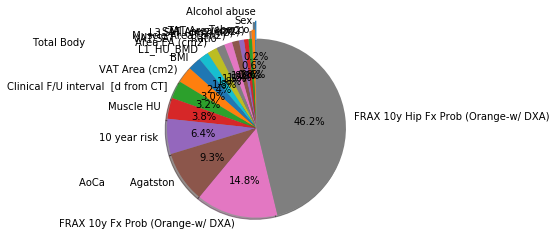

In [25]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['Frogs', 'Hogs', 'Dogs', 'Logs']
sizes = [0.15, 0.30, 0.45, 0.10]
labels = list(temp.keys())
sizes = list(temp.values())
explode = [0]*len(labels)  # only "explode" the 2nd slice (i.e. 'Hogs')
explode[0] = 0.2
explode[1] = 0.1;

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()